In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import superscreen as sc
from superscreen.geometry import box, circle, close_curve

import sys
sys.path.insert(0, "..")
import squids

In [2]:
print(sc.__version__)

0.8.0


In [3]:
squid_modules = {
    "ibm-small": squids.ibm.small,
    "ibm-medium": squids.ibm.medium,
    "ibm-large": squids.ibm.large,
    "ibm-xlarge": squids.ibm.xlarge,
    "huber": squids.huber,
    "hypres-small": squids.hypres.small,
}

In [4]:
squid_with_field_coil = squid_modules["ibm-xlarge"].make_squid()

Remove the BE wiring layer and the field coil/field coil shield.

In [5]:
include_layers = ["W2", "W1"]
include_films = ["pl", "pl_shield1"]
include_holes = ["pl_center"]

layers = [squid_with_field_coil.layers[name] for name in ["W2", "W1"]]
films = [squid_with_field_coil.films[name] for name in ["pl", "pl_shield1"]]
holes = [squid_with_field_coil.holes[name] for name in ["pl_center"]]
abstract_regions = [
    # bounding box
    sc.Polygon("bounding_box", layer="W2", points=box(14, 22, center=(0, -6))),
    # circle within the PL to increase mesh density locally
    sc.Polygon("circle", layer="W2", points=circle(2.5)),
]

squid = sc.Device(
    "ibm_3um",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units="um",
)
# "float32" uses less memory than the default "float64"
squid.dtype = "float32"

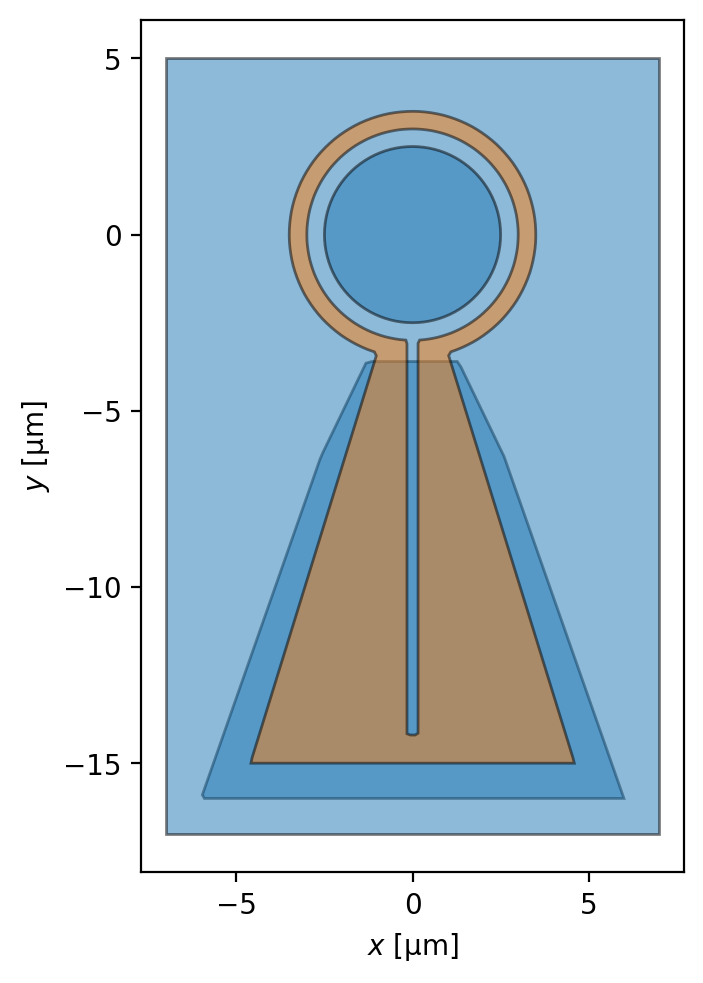

In [6]:
_ = squid.draw()

In [7]:
squid.make_mesh(min_points=5000, smooth=100)

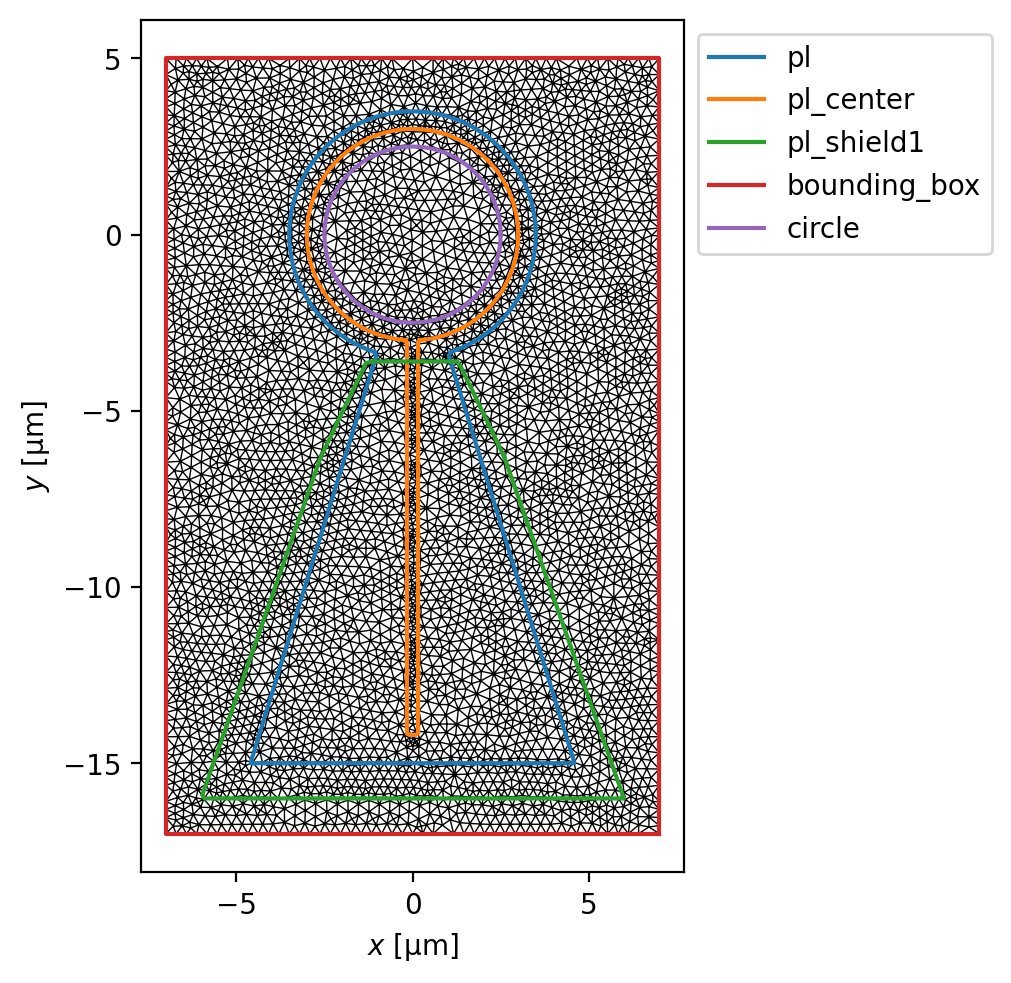

In [8]:
_ = squid.plot(mesh=True)

In [9]:
iterations = 10

solutions = sc.solve(
    squid,
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
    iterations=10,
)

In [10]:
pl_fluxoids = [sum(solution.hole_fluxoid("pl_center")).to("Phi_0") for solution in solutions]

In [11]:
effective_areas = [fluxoid / sc.ureg("1 mT") for fluxoid in pl_fluxoids]
effective_radii = [np.sqrt(area / np.pi).to("um").magnitude for area in effective_areas]

In [12]:
effective_radii

[4.15412860534762,
 3.536709065142047,
 3.695758781521574,
 3.5642780993151533,
 3.609748581147074,
 3.5719068124943343,
 3.5862851416215555,
 3.5742805032458027,
 3.5790441527308574,
 3.5750605699870475,
 3.576679735657242]

## The effective radius is slightly larger than the nominal outer radius because some flux passes through the pickup loop leads.

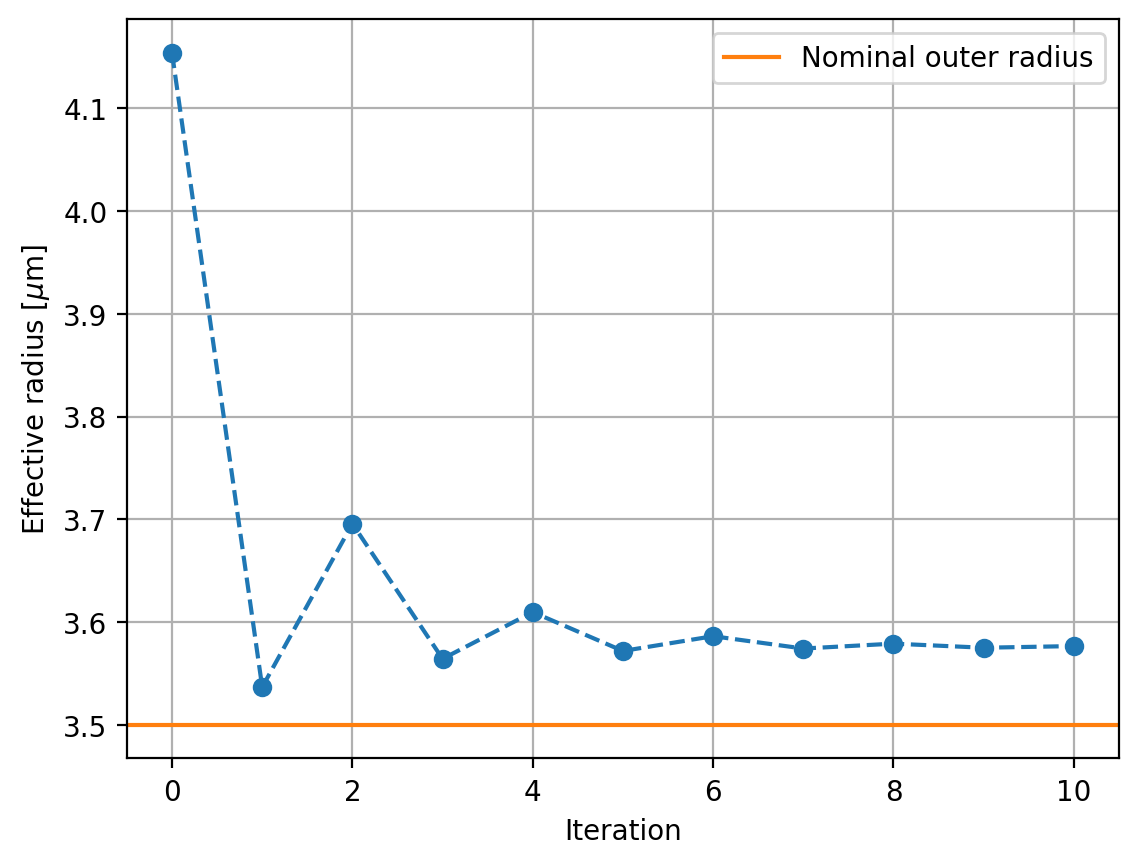

In [13]:
fig, ax = plt.subplots()
ax.plot(range(len(solutions)), effective_radii, "o--")
ax.grid(True)
ax.set_xlabel("Iteration")
ax.set_ylabel("Effective radius [$\\mu$m]")
ax.axhline(3.5, color="C1", label="Nominal outer radius")
_ = ax.legend(loc=0)

## 0th iteration: No interaction between the layers, so the PL leads are effectively unshielded.

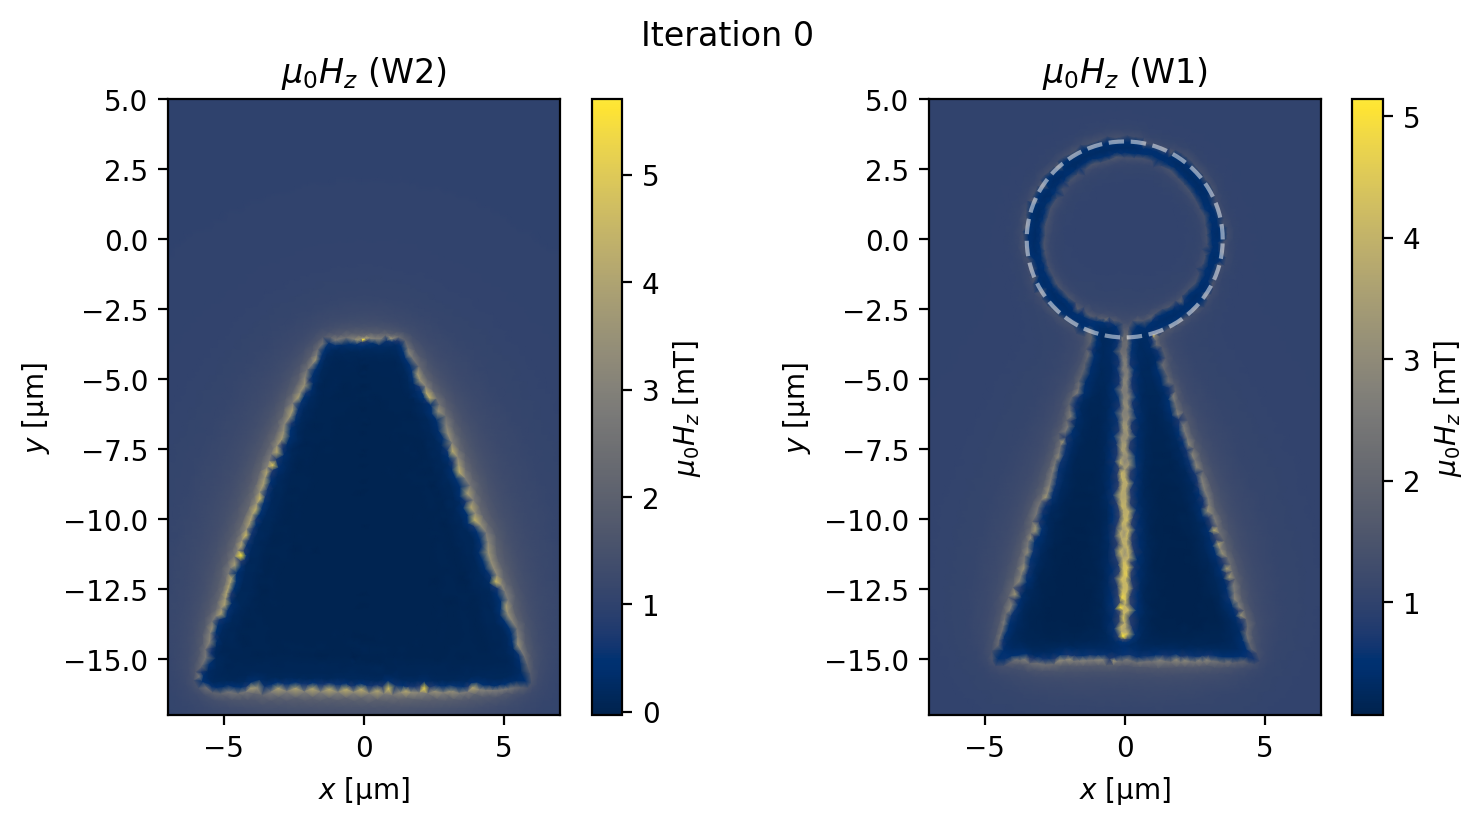

In [14]:
fig, axes = solutions[0].plot_fields(figsize=(9, 4))
axes[-1].plot(*close_curve(circle(3.5)).T, color="w", ls="--", alpha=0.5)
_ = fig.suptitle("Iteration 0")

## 10th iteration: PL leads shielded, reducing the effective area

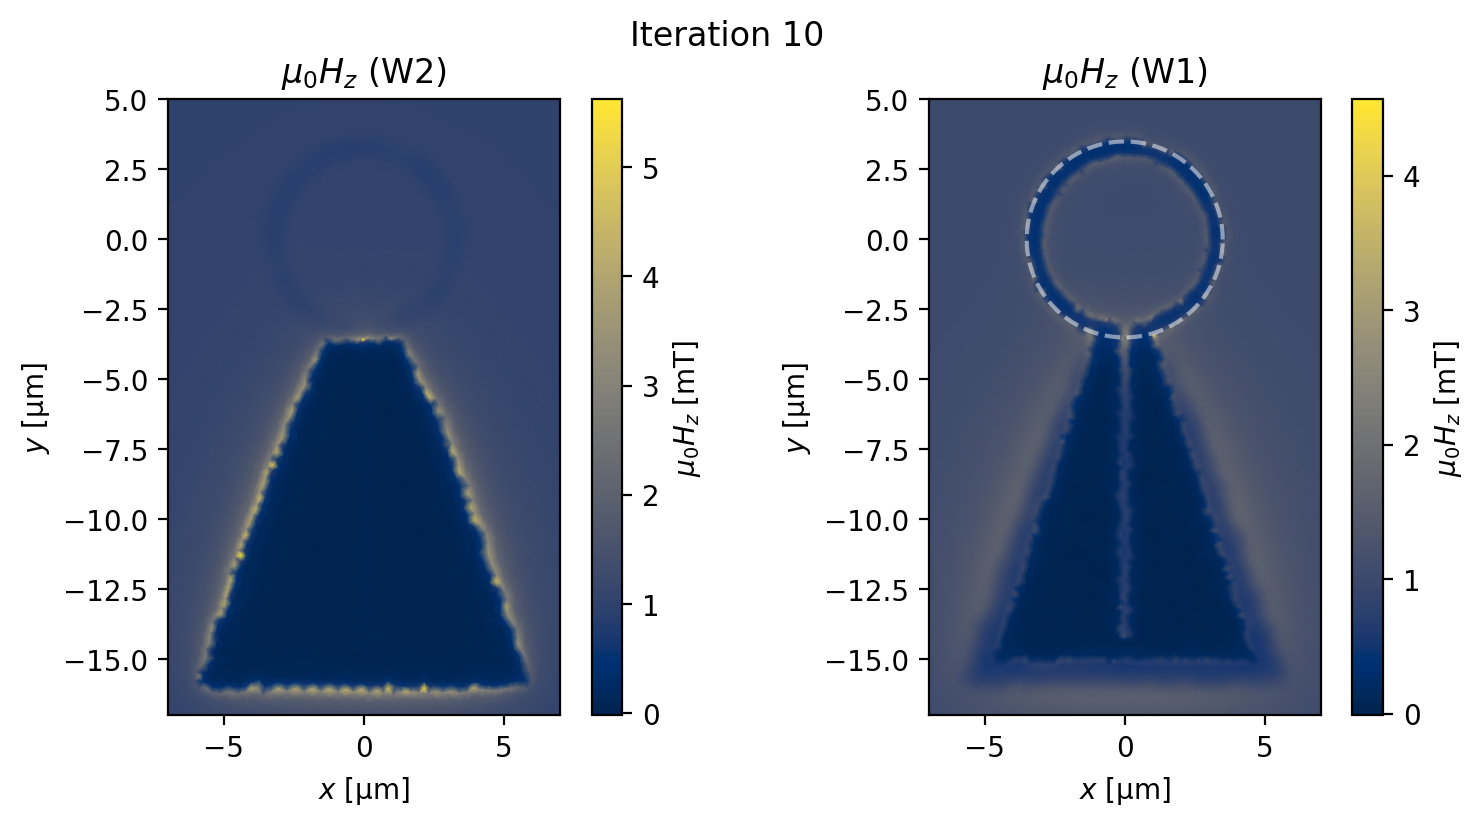

In [15]:
fig, axes = solutions[-1].plot_fields(figsize=(9, 4))
axes[-1].plot(*close_curve(circle(3.5)).T, color="w", ls="--", alpha=0.5)
_ = fig.suptitle(f"Iteration {iterations}")

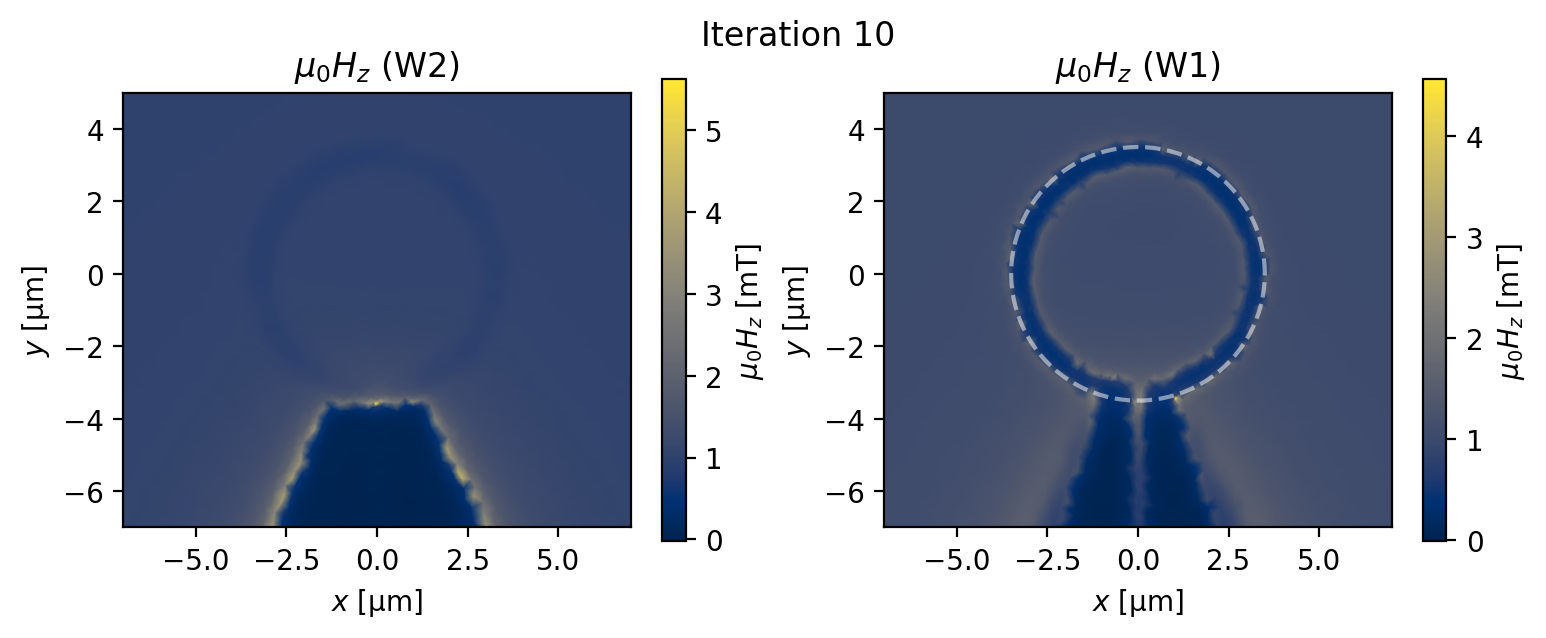

In [16]:
fig, axes = solutions[-1].plot_fields(figsize=(9, 3))
axes[-1].plot(*close_curve(circle(3.5)).T, color="w", ls="--", alpha=0.5)
for ax in axes:
    ax.set_ylim(-7, 5)
_ = fig.suptitle(f"Iteration {iterations}")

In [17]:
sc.version_table()

Software,Version
SuperScreen,0.8.0
Numpy,1.23.3
SciPy,1.9.1
matplotlib,3.6.0
ray,2.0.0
jax,0.3.18
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
